In [1]:
import torch
from copy import deepcopy
from itertools import chain
import math
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt

In [ ]:
#Adam and AdaMax Implementations based on:
#https://github.com/pytorch/pytorch/blob/b7bda236d18815052378c88081f64935427d7716/torch/optim/adamax.py
#https://github.com/pytorch/pytorch/blob/b7bda236d18815052378c88081f64935427d7716/torch/optim/optimizer.py
#https://github.com/pytorch/pytorch/blob/b7bda236d18815052378c88081f64935427d7716/torch/optim/adam.py

In [2]:
class _RequiredParameter(object):
    """Singleton class representing a required parameter for an Optimizer."""
    def __repr__(self):
        return "<required parameter>"

required = _RequiredParameter()


class Optimizer(object):
    r"""Base class for all optimizers.
    .. warning::
        Parameters need to be specified as collections that have a deterministic
        ordering that is consistent between runs. Examples of objects that don't
        satisfy those properties are sets and iterators over values of dictionaries.
    Arguments:
        params (iterable): an iterable of :class:`torch.Tensor` s or
            :class:`dict` s. Specifies what Tensors should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        torch._C._log_api_usage_once("python.optimizer")
        self.defaults = defaults

        if isinstance(params, torch.Tensor):
            raise TypeError("params argument given to the optimizer should be an iterable of Tensors or dicts, but got " + torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'defaults': self.defaults,
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def __repr__(self):
        format_string = self.__class__.__name__ + ' ('
        for i, group in enumerate(self.param_groups):
            format_string += '\n'
            format_string += 'Parameter Group {0}\n'.format(i)
            for key in sorted(group.keys()):
                if key != 'params':
                    format_string += '    {0}: {1}\n'.format(key, group[key])
        format_string += ')'
        return format_string

    def state_dict(self):
        r"""Returns the state of the optimizer as a :class:`dict`.
        It contains two entries:
        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a dict containing all parameter groups
        """
        # Save order indices instead of Tensors
        param_mappings = {}
        start_index = 0

        def pack_group(group):
            nonlocal start_index
            packed = {k: v for k, v in group.items() if k != 'params'}
            param_mappings.update({id(p): i for i, p in enumerate(group['params'], start_index)
                                   if id(p) not in param_mappings})
            packed['params'] = [param_mappings[id(p)] for p in group['params']]
            start_index += len(packed['params'])
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use order indices as keys
        packed_state = {(param_mappings[id(k)] if isinstance(k, torch.Tensor) else k): v
                        for k, v in self.state.items()}
        return {'state': packed_state, 'param_groups': param_groups}

    def load_state_dict(self, state_dict):
        r"""Loads the optimizer state.
        Arguments:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain.from_iterable((g['params'] for g in saved_groups)),
                      chain.from_iterable((g['params'] for g in groups)))}

        def cast(param, value):
            r"""Make a deep copy of value, casting all tensors to device of param."""
            if isinstance(value, torch.Tensor):
                # Floating-point types are a bit special here. They are the only ones
                # that are assumed to always match the type of params.
                if param.is_floating_point():
                    value = value.to(param.dtype)
                value = value.to(param.device)
                return value
            elif isinstance(value, dict):
                return {k: cast(param, v) for k, v in value.items()}
            elif isinstance(value, container_abcs.Iterable):
                return type(value)(cast(param, v) for v in value)
            else:
                return value

        # Copy state assigned to params (and cast tensors to appropriate types).
        # State that is not assigned to params is copied as is (needed for
        # backward compatibility).
        state = defaultdict(dict)
        for k, v in state_dict['state'].items():
            if k in id_map:
                param = id_map[k]
                state[param] = cast(param, v)
            else:
                state[k] = v

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self):
        r"""Clears the gradients of all optimized :class:`torch.Tensor` s."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()

    def step(self, closure):
        r"""Performs a single optimization step (parameter update).
        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        .. note::
            Unless otherwise specified, this function should not modify the
            ``.grad`` field of the parameters.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        r"""Add a param group to the :class:`Optimizer` s `param_groups`.
        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.
        Arguments:
            param_group (dict): Specifies what Tensors should be optimized along with group
            specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, torch.Tensor):
            param_group['params'] = [params]
        elif isinstance(params, set):
            raise TypeError('optimizer parameters need to be organized in ordered collections, but '
                            'the ordering of tensors in sets will change between runs. Please use a list instead.')
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, torch.Tensor):
                raise TypeError("optimizer can only optimize Tensors, but one of the params is " + torch.typename(param))
            if not param.is_leaf:
                raise ValueError("can't optimize a non-leaf Tensor")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)

In [3]:
class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        sz (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, sz=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= sz:
            raise ValueError("Invalid learning rate: {}".format(sz))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(sz=sz, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)

    @torch.no_grad()
    def step(self, size=0.001):
        """Performs a single optimization step.
        Arguments:
            size(optional): for decaying step size
        """
        loss = None
        sz=size

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['sz'] / bias_correction1

                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [4]:
class Adamax(Optimizer):
    """Implements Adamax algorithm (a variant of Adam based on infinity norm).
    It has been proposed in `Adam: A Method for Stochastic Optimization`__.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        sz (float, optional): step size (default: 2e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    __ https://arxiv.org/abs/1412.6980
    """

    def __init__(self, params, sz=2e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= sz:
            raise ValueError("Invalid learning rate: {}".format(sz))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(sz=sz, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adamax, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single optimization step.
        Arguments:
        """
        loss = None

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Adamax does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['exp_inf'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_inf = state['exp_avg'], state['exp_inf']
                beta1, beta2 = group['betas']
                eps = group['eps']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                # Update biased first moment estimate.
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update the exponentially weighted infinity norm.
                norm_buf = torch.cat([exp_inf.mul_(beta2).unsqueeze(0), grad.abs().add_(eps).unsqueeze_(0)], 0)
                torch.max(norm_buf, 0, keepdim=False, out=(exp_inf, exp_inf.new().long()))

                bias_correction = 1 - beta1 ** state['step']
                csz = group['sz'] / bias_correction

                p.addcdiv_(exp_avg, exp_inf, value=-csz)

        return loss

In [5]:
#Load data and set hyperparameters
input_size = 784 #images in MNIST dataset are 28x28 pixels = 784 features
output_size = 10 #MNIST dataset has 10 classes (0-9)
num_epochs = 20
batch_size = 128 #total number of images is 60000
step_size = 0.001

train_dataset = torchvision.datasets.MNIST(root='Data', train = True, transform = transforms.ToTensor(), download = True) #download data and transform them to pytorch tensors
test_dataset = torchvision.datasets.MNIST(root='Data', train = False, transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True) #create dataLoader to divide data based on batch size and shuffle it
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [6]:
#Define models
class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(784, 10)
    def forward(self, x):
        out = self.linear(x)
        return(out)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1000, 10)
        #self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu1(out)
        #out = self.dropout(out)
        out = self.fc3(out)
        return out
    
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) # channels in, out, kernel size
        self.conv2 = nn.Conv2d(10, 50, 5)
        self.conv3 = nn.Conv2d(50, 100, 5)
        self.fc1 = nn.Linear(50*3*3, 200) # kernel, stride
        self.fc2 = nn.Linear(200, 10)
        #self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        #[128, 1, 28, 28]
        x = self.conv1(x)
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(x)
        #print(x.shape) # [128, 20, 11, 11]
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(x)
        #print(x.shape) # [128, 50, 3, 3]
        
        x = x.view(-1, 50*3*3)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
#PART 1 multiclass logistic regression with adam
step_size = 0.001

model = Logistic()
criterion = nn.CrossEntropyLoss() #cross entropy loss for multiclass classification
optimizer = Adam(model.parameters(), sz=step_size, weight_decay=0) #weight decay is used for l2-regularization

part1_losses = []
total_step = len(train_loader) #total number of iterations
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #enumerate is used to give the value of i also
        images = images.reshape(-1, 28*28) #600,784
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step(step_size)
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part1_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)
    
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #return max value and the indices
        total += labels.size(0)
        correct += (predicted==labels).sum()
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total)) 

Epoch [1/20], Iteration [100/469], Loss: 0.7019
Epoch [1/20], Iteration [200/469], Loss: 0.6146
Epoch [1/20], Iteration [300/469], Loss: 0.4099
Epoch [1/20], Iteration [400/469], Loss: 0.4030
Epoch [2/20], Iteration [100/469], Loss: 0.3565
Epoch [2/20], Iteration [200/469], Loss: 0.4149
Epoch [2/20], Iteration [300/469], Loss: 0.4305
Epoch [2/20], Iteration [400/469], Loss: 0.3590
Epoch [3/20], Iteration [100/469], Loss: 0.3580
Epoch [3/20], Iteration [200/469], Loss: 0.2458
Epoch [3/20], Iteration [300/469], Loss: 0.3188
Epoch [3/20], Iteration [400/469], Loss: 0.3111
Epoch [4/20], Iteration [100/469], Loss: 0.2698
Epoch [4/20], Iteration [200/469], Loss: 0.4068
Epoch [4/20], Iteration [300/469], Loss: 0.3236
Epoch [4/20], Iteration [400/469], Loss: 0.2850
Epoch [5/20], Iteration [100/469], Loss: 0.3065
Epoch [5/20], Iteration [200/469], Loss: 0.2994
Epoch [5/20], Iteration [300/469], Loss: 0.2786
Epoch [5/20], Iteration [400/469], Loss: 0.2494
Epoch [6/20], Iteration [100/469], Loss:

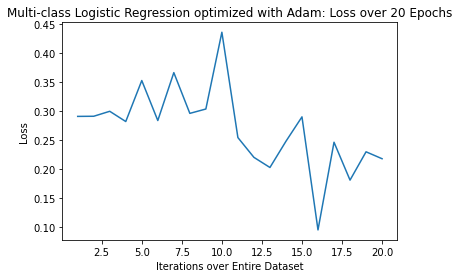

In [8]:
x_axis = range(1,len(part1_losses)+1)
y_axis = part1_losses

plt.plot(x_axis, y_axis)
plt.title('Multi-class Logistic Regression optimized with Adam: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [9]:
#PART 2 multilayer neural network with adam
step_size = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), sz = step_size, weight_decay=0)

part2_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part2_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.3417
Epoch [1/20], Iteration [200/469], Loss: 0.2140
Epoch [1/20], Iteration [300/469], Loss: 0.1550
Epoch [1/20], Iteration [400/469], Loss: 0.0854
Epoch [2/20], Iteration [100/469], Loss: 0.1215
Epoch [2/20], Iteration [200/469], Loss: 0.1045
Epoch [2/20], Iteration [300/469], Loss: 0.0546
Epoch [2/20], Iteration [400/469], Loss: 0.0968
Epoch [3/20], Iteration [100/469], Loss: 0.0478
Epoch [3/20], Iteration [200/469], Loss: 0.0734
Epoch [3/20], Iteration [300/469], Loss: 0.0438
Epoch [3/20], Iteration [400/469], Loss: 0.0825
Epoch [4/20], Iteration [100/469], Loss: 0.0163
Epoch [4/20], Iteration [200/469], Loss: 0.0235
Epoch [4/20], Iteration [300/469], Loss: 0.0103
Epoch [4/20], Iteration [400/469], Loss: 0.0685
Epoch [5/20], Iteration [100/469], Loss: 0.0462
Epoch [5/20], Iteration [200/469], Loss: 0.0184
Epoch [5/20], Iteration [300/469], Loss: 0.0340
Epoch [5/20], Iteration [400/469], Loss: 0.0108
Epoch [6/20], Iteration [100/469], Loss:

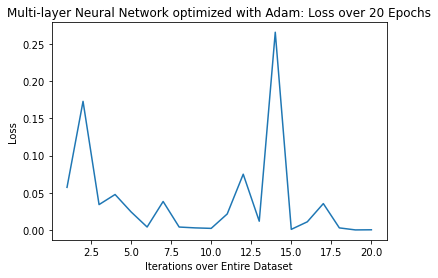

In [10]:
x_axis = range(1,len(part2_losses)+1)
y_axis = part2_losses

plt.plot(x_axis, y_axis)
plt.title('Multi-layer Neural Network optimized with Adam: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [11]:
#PART 3 convolutional neural network with adam
step_size = 0.001
    
model = ConvNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), sz=step_size, weight_decay=0)

part3_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part3_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.2528
Epoch [1/20], Iteration [200/469], Loss: 0.1292
Epoch [1/20], Iteration [300/469], Loss: 0.1662
Epoch [1/20], Iteration [400/469], Loss: 0.0984
Epoch [2/20], Iteration [100/469], Loss: 0.0248
Epoch [2/20], Iteration [200/469], Loss: 0.1007
Epoch [2/20], Iteration [300/469], Loss: 0.0300
Epoch [2/20], Iteration [400/469], Loss: 0.1114
Epoch [3/20], Iteration [100/469], Loss: 0.0886
Epoch [3/20], Iteration [200/469], Loss: 0.0488
Epoch [3/20], Iteration [300/469], Loss: 0.1248
Epoch [3/20], Iteration [400/469], Loss: 0.0122
Epoch [4/20], Iteration [100/469], Loss: 0.0076
Epoch [4/20], Iteration [200/469], Loss: 0.0824
Epoch [4/20], Iteration [300/469], Loss: 0.0068
Epoch [4/20], Iteration [400/469], Loss: 0.0244
Epoch [5/20], Iteration [100/469], Loss: 0.0322
Epoch [5/20], Iteration [200/469], Loss: 0.0196
Epoch [5/20], Iteration [300/469], Loss: 0.0222
Epoch [5/20], Iteration [400/469], Loss: 0.0271
Epoch [6/20], Iteration [100/469], Loss:

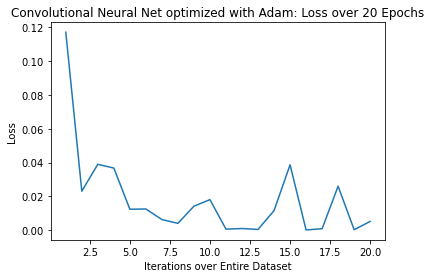

In [12]:
x_axis = range(1,len(part3_losses)+1)
y_axis = part3_losses

plt.plot(x_axis, y_axis)
plt.title('Convolutional Neural Net optimized with Adam: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [13]:
#Part 4 multiclass logistic regression with adamax
step_size = 0.001

model = Logistic()
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), sz=step_size, weight_decay=0)

part4_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)#600,784
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch%5 == 0):
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part4_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #return max value and the indices
        total += labels.size(0)
        correct += (predicted==labels).sum()
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total)) 

Epoch [1/20], Iteration [100/469], Loss: 1.0357
Epoch [1/20], Iteration [200/469], Loss: 0.7426
Epoch [1/20], Iteration [300/469], Loss: 0.6879
Epoch [1/20], Iteration [400/469], Loss: 0.5820
Epoch [6/20], Iteration [100/469], Loss: 0.3949
Epoch [6/20], Iteration [200/469], Loss: 0.5530
Epoch [6/20], Iteration [300/469], Loss: 0.2348
Epoch [6/20], Iteration [400/469], Loss: 0.3462
Epoch [11/20], Iteration [100/469], Loss: 0.2078
Epoch [11/20], Iteration [200/469], Loss: 0.2027
Epoch [11/20], Iteration [300/469], Loss: 0.3015
Epoch [11/20], Iteration [400/469], Loss: 0.2323
Epoch [16/20], Iteration [100/469], Loss: 0.2312
Epoch [16/20], Iteration [200/469], Loss: 0.1747
Epoch [16/20], Iteration [300/469], Loss: 0.1617
Epoch [16/20], Iteration [400/469], Loss: 0.2701
Accuracy on 10000 test images: 92.37999725341797 %


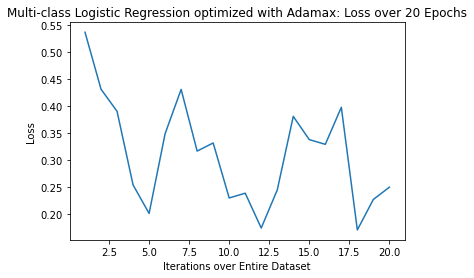

In [14]:
x_axis = range(1,len(part4_losses)+1)
y_axis = part4_losses

plt.plot(x_axis, y_axis)
plt.title('Multi-class Logistic Regression optimized with Adamax: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [15]:
#PART 5 multilayer neural network with adamax
step_size = 0.001
    
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), sz=step_size, weight_decay=0)

part5_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part5_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.3965
Epoch [1/20], Iteration [200/469], Loss: 0.2243
Epoch [1/20], Iteration [300/469], Loss: 0.1957
Epoch [1/20], Iteration [400/469], Loss: 0.1595
Epoch [2/20], Iteration [100/469], Loss: 0.1417
Epoch [2/20], Iteration [200/469], Loss: 0.1030
Epoch [2/20], Iteration [300/469], Loss: 0.1272
Epoch [2/20], Iteration [400/469], Loss: 0.1404
Epoch [3/20], Iteration [100/469], Loss: 0.0576
Epoch [3/20], Iteration [200/469], Loss: 0.0748
Epoch [3/20], Iteration [300/469], Loss: 0.0525
Epoch [3/20], Iteration [400/469], Loss: 0.1347
Epoch [4/20], Iteration [100/469], Loss: 0.0664
Epoch [4/20], Iteration [200/469], Loss: 0.0392
Epoch [4/20], Iteration [300/469], Loss: 0.0154
Epoch [4/20], Iteration [400/469], Loss: 0.0321
Epoch [5/20], Iteration [100/469], Loss: 0.0216
Epoch [5/20], Iteration [200/469], Loss: 0.0303
Epoch [5/20], Iteration [300/469], Loss: 0.0485
Epoch [5/20], Iteration [400/469], Loss: 0.0471
Epoch [6/20], Iteration [100/469], Loss:

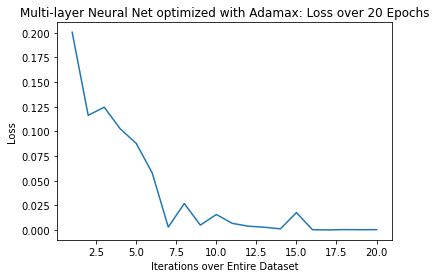

In [16]:
x_axis = range(1,len(part5_losses)+1)
y_axis = part5_losses

plt.plot(x_axis, y_axis)
plt.title('Multi-layer Neural Net optimized with Adamax: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [17]:
#PART 6 convolutional neural network with adamax
step_size = 0.001x_axis = range(1,len(part5_losses)+1)
y_axis = part5_losses

plt.plot(x_axis, y_axis)
plt.title('Multi-layer Neural Netw optimized with Adamax: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()
    
model = ConvNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), sz=step_size, weight_decay=0)

part6_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part6_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.4924
Epoch [1/20], Iteration [200/469], Loss: 0.3279
Epoch [1/20], Iteration [300/469], Loss: 0.2377
Epoch [1/20], Iteration [400/469], Loss: 0.2140
Epoch [2/20], Iteration [100/469], Loss: 0.0966
Epoch [2/20], Iteration [200/469], Loss: 0.0879
Epoch [2/20], Iteration [300/469], Loss: 0.0908
Epoch [2/20], Iteration [400/469], Loss: 0.0787
Epoch [3/20], Iteration [100/469], Loss: 0.0563
Epoch [3/20], Iteration [200/469], Loss: 0.0981
Epoch [3/20], Iteration [300/469], Loss: 0.1458
Epoch [3/20], Iteration [400/469], Loss: 0.0879
Epoch [4/20], Iteration [100/469], Loss: 0.0623
Epoch [4/20], Iteration [200/469], Loss: 0.1338
Epoch [4/20], Iteration [300/469], Loss: 0.0431
Epoch [4/20], Iteration [400/469], Loss: 0.0763
Epoch [5/20], Iteration [100/469], Loss: 0.0487
Epoch [5/20], Iteration [200/469], Loss: 0.0757
Epoch [5/20], Iteration [300/469], Loss: 0.0319
Epoch [5/20], Iteration [400/469], Loss: 0.0569
Epoch [6/20], Iteration [100/469], Loss:

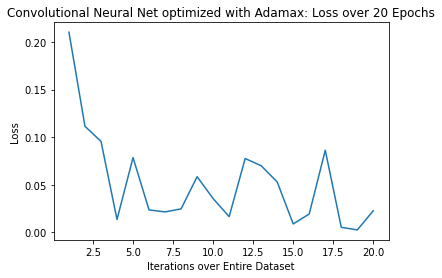

In [29]:
x_axis = range(1,len(part6_losses)+1)
y_axis = part6_losses

plt.plot(x_axis, y_axis)
plt.title('Convolutional Neural Net optimized with Adamax: Loss over 20 Epochs')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

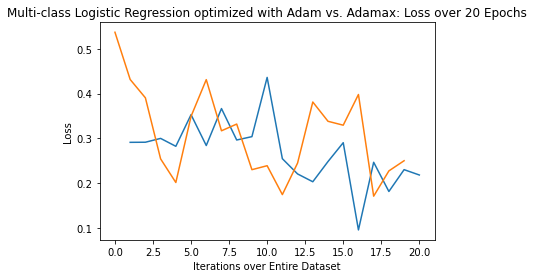

In [33]:
#comparison 1
x_axis = range(1,len(part1_losses)+1)

plt.plot(x_axis, part1_losses, part4_losses)
plt.title('Multi-class Logistic Regression optimized with Adam (blue) vs. Adamax (orange)')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

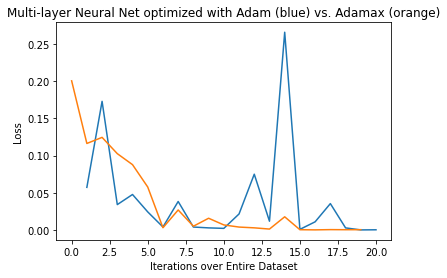

In [45]:
#comparison 2
x_axis = range(1,len(part1_losses)+1)

plt.plot(x_axis, part2_losses, part5_losses)
plt.title('Multi-layer Neural Net optimized with Adam (blue) vs. Adamax (orange)')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

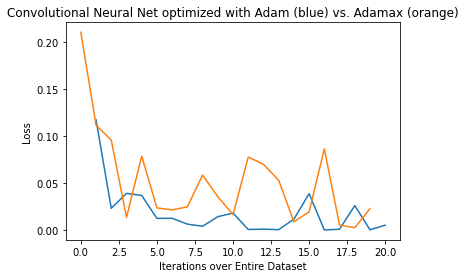

In [44]:
#comparison 3
x_axis = range(1,len(part1_losses)+1)

plt.plot(x_axis, part3_losses, part6_losses)
plt.title('Convolutional Neural Net optimized with Adam (blue) vs. Adamax (orange)')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

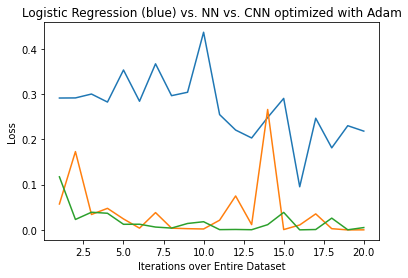

In [53]:
#comparison 4
x_axis = range(1,len(part2_losses)+1)

plt.plot(x_axis, part1_losses)
plt.plot(x_axis, part2_losses)
plt.plot(x_axis, part3_losses)
plt.title('Logistic Regression (blue) vs. NN (orange) vs. CNN (green) optimized with Adam')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

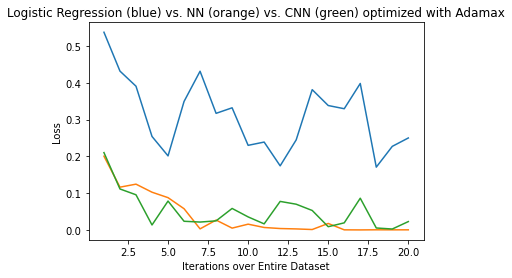

In [57]:
#comparison 5
x_axis = range(1,len(part1_losses)+1)

plt.plot(x_axis, part4_losses)
plt.plot(x_axis, part5_losses)
plt.plot(x_axis, part6_losses)
plt.title('Logistic Regression (blue) vs. NN (orange) vs. CNN (green) optimized with Adamax')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

In [58]:
class dropoutNeuralNet(nn.Module):
    def __init__(self):
        super(dropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1000, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out
    
class dropoutConvNeuralNet(nn.Module):
    def __init__(self):
        super(dropoutConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) # channels in, out, kernel size
        self.conv2 = nn.Conv2d(10, 50, 5)
        self.conv3 = nn.Conv2d(50, 100, 5)
        self.fc1 = nn.Linear(50*3*3, 200) # kernel, stride
        self.fc2 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        #[128, 1, 28, 28]
        x = self.conv1(x)
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(x)
        #print(x.shape) # [128, 20, 11, 11]
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(x)
        #print(x.shape) # [128, 50, 3, 3]
        
        x = x.view(-1, 50*3*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [59]:
#PART 7 multilayer neural network with adam and dropout
step_size = 0.001
    
model = dropoutNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), sz = step_size, weight_decay=0)

part7_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part7_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.2351
Epoch [1/20], Iteration [200/469], Loss: 0.2582
Epoch [1/20], Iteration [300/469], Loss: 0.0654
Epoch [1/20], Iteration [400/469], Loss: 0.0975
Epoch [2/20], Iteration [100/469], Loss: 0.1040
Epoch [2/20], Iteration [200/469], Loss: 0.0266
Epoch [2/20], Iteration [300/469], Loss: 0.0403
Epoch [2/20], Iteration [400/469], Loss: 0.1055
Epoch [3/20], Iteration [100/469], Loss: 0.1769
Epoch [3/20], Iteration [200/469], Loss: 0.0758
Epoch [3/20], Iteration [300/469], Loss: 0.0387
Epoch [3/20], Iteration [400/469], Loss: 0.0499
Epoch [4/20], Iteration [100/469], Loss: 0.0185
Epoch [4/20], Iteration [200/469], Loss: 0.1904
Epoch [4/20], Iteration [300/469], Loss: 0.0284
Epoch [4/20], Iteration [400/469], Loss: 0.0559
Epoch [5/20], Iteration [100/469], Loss: 0.0298
Epoch [5/20], Iteration [200/469], Loss: 0.0280
Epoch [5/20], Iteration [300/469], Loss: 0.0043
Epoch [5/20], Iteration [400/469], Loss: 0.0179
Epoch [6/20], Iteration [100/469], Loss:

In [60]:
#PART 8 convolutional neural network with adam and dropout
step_size = 0.001
    
model = dropoutConvNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), sz=step_size, weight_decay=0)

part8_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part8_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.3646
Epoch [1/20], Iteration [200/469], Loss: 0.2415
Epoch [1/20], Iteration [300/469], Loss: 0.1078
Epoch [1/20], Iteration [400/469], Loss: 0.1160
Epoch [2/20], Iteration [100/469], Loss: 0.0567
Epoch [2/20], Iteration [200/469], Loss: 0.0575
Epoch [2/20], Iteration [300/469], Loss: 0.0567
Epoch [2/20], Iteration [400/469], Loss: 0.1095
Epoch [3/20], Iteration [100/469], Loss: 0.0941
Epoch [3/20], Iteration [200/469], Loss: 0.0946
Epoch [3/20], Iteration [300/469], Loss: 0.0318
Epoch [3/20], Iteration [400/469], Loss: 0.0234
Epoch [4/20], Iteration [100/469], Loss: 0.0103
Epoch [4/20], Iteration [200/469], Loss: 0.0423
Epoch [4/20], Iteration [300/469], Loss: 0.0962
Epoch [4/20], Iteration [400/469], Loss: 0.1466
Epoch [5/20], Iteration [100/469], Loss: 0.0151
Epoch [5/20], Iteration [200/469], Loss: 0.0889
Epoch [5/20], Iteration [300/469], Loss: 0.0488
Epoch [5/20], Iteration [400/469], Loss: 0.0680
Epoch [6/20], Iteration [100/469], Loss:

In [61]:
#PART 9 multilayer neural network with adamax and dropout
step_size = 0.001
    
model = dropoutNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), sz = step_size, weight_decay=0)

part9_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part9_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.2574
Epoch [1/20], Iteration [200/469], Loss: 0.2062
Epoch [1/20], Iteration [300/469], Loss: 0.2091
Epoch [1/20], Iteration [400/469], Loss: 0.2277
Epoch [2/20], Iteration [100/469], Loss: 0.1147
Epoch [2/20], Iteration [200/469], Loss: 0.1106
Epoch [2/20], Iteration [300/469], Loss: 0.1648
Epoch [2/20], Iteration [400/469], Loss: 0.1309
Epoch [3/20], Iteration [100/469], Loss: 0.0787
Epoch [3/20], Iteration [200/469], Loss: 0.0574
Epoch [3/20], Iteration [300/469], Loss: 0.1497
Epoch [3/20], Iteration [400/469], Loss: 0.1191
Epoch [4/20], Iteration [100/469], Loss: 0.0494
Epoch [4/20], Iteration [200/469], Loss: 0.0784
Epoch [4/20], Iteration [300/469], Loss: 0.0316
Epoch [4/20], Iteration [400/469], Loss: 0.1119
Epoch [5/20], Iteration [100/469], Loss: 0.0475
Epoch [5/20], Iteration [200/469], Loss: 0.0639
Epoch [5/20], Iteration [300/469], Loss: 0.0290
Epoch [5/20], Iteration [400/469], Loss: 0.0332
Epoch [6/20], Iteration [100/469], Loss:

In [62]:
#PART 10 convolutional neural network with adamax and dropout
step_size = 0.001
    
model = dropoutConvNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), sz=step_size, weight_decay=0)

part10_losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    part10_losses.append(loss.item())
    step_size = step_size/math.sqrt(epoch+1)

with torch.no_grad():
    correct = 0 
    total = 0
    for images, labels in (test_loader):
        images= images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=predicted.size(0)
        correct += (predicted==labels).sum()
        
    print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/20], Iteration [100/469], Loss: 0.5346
Epoch [1/20], Iteration [200/469], Loss: 0.2968
Epoch [1/20], Iteration [300/469], Loss: 0.2468
Epoch [1/20], Iteration [400/469], Loss: 0.3087
Epoch [2/20], Iteration [100/469], Loss: 0.2664
Epoch [2/20], Iteration [200/469], Loss: 0.0774
Epoch [2/20], Iteration [300/469], Loss: 0.0890
Epoch [2/20], Iteration [400/469], Loss: 0.2106
Epoch [3/20], Iteration [100/469], Loss: 0.1606
Epoch [3/20], Iteration [200/469], Loss: 0.0824
Epoch [3/20], Iteration [300/469], Loss: 0.0774
Epoch [3/20], Iteration [400/469], Loss: 0.1731
Epoch [4/20], Iteration [100/469], Loss: 0.0436
Epoch [4/20], Iteration [200/469], Loss: 0.1256
Epoch [4/20], Iteration [300/469], Loss: 0.1102
Epoch [4/20], Iteration [400/469], Loss: 0.0477
Epoch [5/20], Iteration [100/469], Loss: 0.0589
Epoch [5/20], Iteration [200/469], Loss: 0.0896
Epoch [5/20], Iteration [300/469], Loss: 0.0590
Epoch [5/20], Iteration [400/469], Loss: 0.0743
Epoch [6/20], Iteration [100/469], Loss:

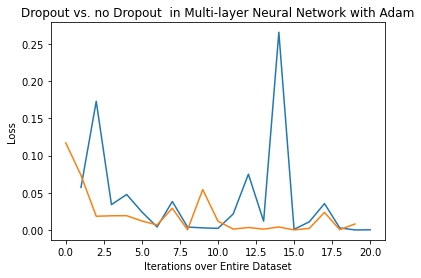

In [70]:
#comparison 7 (6 skipped due to .png name conflict)
x_axis = range(1,len(part2_losses)+1)

plt.plot(x_axis, part2_losses, part7_losses)
plt.title('Dropout (orange) vs. no Dropout (blue) in Multi-layer Neural Network with Adam')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

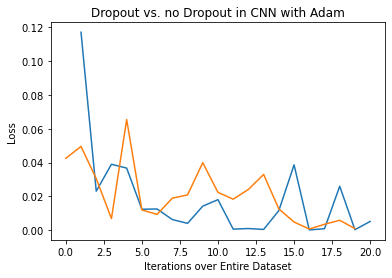

In [65]:
#comparison 8
plt.plot(x_axis, part3_losses, part8_losses)
plt.title('Dropout (orange) vs. no Dropout (blue) in CNN with Adam')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

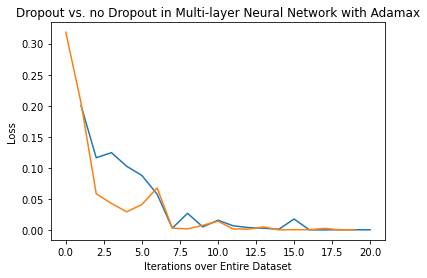

In [68]:
#comparison 9
plt.plot(x_axis, part5_losses, part9_losses)
plt.title('Dropout (orange) vs. no Dropout (blue) in Multi-layer Neural Network with Adamax')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()

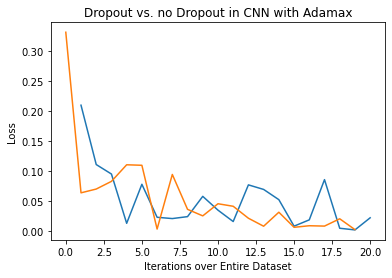

In [67]:
#comparison 10
plt.plot(x_axis, part6_losses, part10_losses)
plt.title('Dropout (orange) vs. no Dropout (blue) in CNN with Adamax')
plt.xlabel('Iterations over Entire Dataset')
plt.ylabel('Loss')
plt.show()